In [ ]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, concatenate
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv('/content/data_for_test.csv',sep=',')

In [ ]:
df.drop(columns=["name","real_name","full_name","height","weight"],inplace=True)

df.dropna(subset=['creator'],inplace=True)
df.dropna(subset=['history_text'],inplace=True)

In [ ]:
df.overall_score = df.overall_score.replace(["∞","-"],"0")
df.overall_score = df.overall_score.astype(int)
df.overall_score = df.overall_score.replace(0,df.overall_score.mean())

df.gender = df.gender.fillna("Male")
df.gender = df.gender.map({"Male":1,"Female":2})

labelencoder = LabelEncoder()
df.type_race = labelencoder.fit_transform(df.type_race.astype(str))

In [ ]:
scaler = StandardScaler()

df[["overall_score","intelligence_score","strength_score","speed_score","durability_score","power_score","combat_score"]] = scaler.fit_transform(df[["overall_score","intelligence_score","strength_score","speed_score","durability_score","power_score","combat_score"]])

In [ ]:
labels = pd.get_dummies(df["creator"])
df.drop(columns=["creator"],inplace=True)

In [ ]:
trainAttrX, testAttrX, trainTextX, testTextX = train_test_split(df.drop("history_text",axis=1), df.history_text, test_size=0.25, random_state=42)
train_y, test_y = train_test_split(labels, test_size=0.25, random_state=42)

In [ ]:
max_features = 20000

tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(df.history_text.to_list())

list_tokenized_train = tokenizer.texts_to_sequences(trainTextX)
list_tokenized_test = tokenizer.texts_to_sequences(testTextX)

(array([630., 121.,  68.,  34.,  24.,   7.,   5.,   9.,   3.,   4.,   3.,
          4.,   1.,   2.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   0.,
          2.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.00000000e+00, 4.88066667e+02, 9.75133333e+02, 1.46220000e+03,
        1.94926667e+03, 2.43633333e+03, 2.92340000e+03, 3.41046667e+03,
        3.89753333e+03, 4.38460000e+03, 4.87166667e+03, 5.35873333e+03,
        5.84580000e+03, 6.33286667e+03, 6.81993333e+03, 7.30700000e+03,
        7.79406667e+03, 8.28113333e+03, 8.76820000e+03, 9.25526667e+03,
        9.74233333e+03, 1.02294000e+04, 1.07164667e+04, 1.12035333e+04,
        1.16906000e+04, 1.21776667e+04, 1.26647333e+04, 1.31518000e+04,
        1.36388667e+04, 1.41259333e+04, 1.46130000e+04]),
 <a list of 30 Patch objects>)

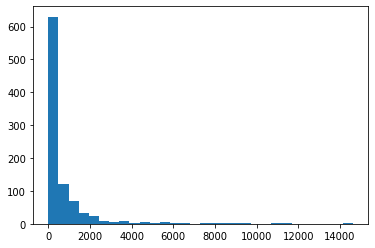

In [ ]:
sentenceLength = [len(one_comment) for one_comment in list_tokenized_train]

plt.hist(sentenceLength, bins = 30)

In [ ]:
max_sen_len = 2500

trainTextX = pad_sequences(list_tokenized_train, maxlen = max_sen_len)
testTextX = pad_sequences(list_tokenized_test, maxlen = max_sen_len)

In [ ]:
# LSTM input
input_1 = tf.keras.layers.Input(shape=(max_sen_len,))
input_2 = tf.keras.layers.Embedding(max_features, 
                        128, 
                        input_length = max_sen_len)(input_1)

lstm_1 = tf.keras.layers.LSTM(100, return_sequences = True)(input_2)

pool_1 = tf.keras.layers.GlobalMaxPool1D()(lstm_1)

dense_2 = tf.keras.layers.Dense(50, activation="relu")(pool_1)

# The MLP input
input__1 = tf.keras.layers.Input(shape=(trainAttrX.shape[1],))
dense__1 = tf.keras.layers.Dense(100, activation="relu")(input__1)
dense__2 = tf.keras.layers.Dense(50, activation="relu")(dense__1)

# Concatenate
concat = tf.keras.layers.Concatenate()([dense__2, dense_2])

n_classes = 41

dense___1 = tf.keras.layers.Dense(100, activation="relu")(concat)

# output layer
output = tf.keras.layers.Dense(units=n_classes,
                               activation=tf.keras.activations.softmax)(dense___1)

model = tf.keras.Model(inputs=[input__1,input_1], outputs=[output])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 2500)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 2500, 128)    2560000     input_9[0][0]                    
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 9)]          0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 2500, 100)    91600       embedding_3[0][0]                
____________________________________________________________________________________________

In [ ]:
opt = Adam(learning_rate=1e-3)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

History = model.fit(
	x=[trainAttrX, trainTextX], y=train_y,
	validation_data=([testAttrX, testTextX], test_y),
	epochs=15, batch_size=8)

Epoch 1/15
116/116 [==============================] - 17s 132ms/step - loss: 1.9861 - accuracy: 0.4383 - val_loss: 1.6496 - val_accuracy: 0.4790
Epoch 2/15
116/116 [==============================] - 15s 130ms/step - loss: 1.6278 - accuracy: 0.4892 - val_loss: 1.6246 - val_accuracy: 0.4660
Epoch 3/15
116/116 [==============================] - 16s 134ms/step - loss: 1.5130 - accuracy: 0.5206 - val_loss: 1.4518 - val_accuracy: 0.5922
Epoch 4/15
116/116 [==============================] - 15s 131ms/step - loss: 1.1789 - accuracy: 0.6688 - val_loss: 1.2304 - val_accuracy: 0.6958
Epoch 5/15
116/116 [==============================] - 15s 127ms/step - loss: 0.7228 - accuracy: 0.8052 - val_loss: 1.0781 - val_accuracy: 0.7055
Epoch 6/15
116/116 [==============================] - 15s 128ms/step - loss: 0.5484 - accuracy: 0.8550 - val_loss: 1.0135 - val_accuracy: 0.7605
Epoch 7/15
116/116 [==============================] - 15s 132ms/step - loss: 0.4639 - accuracy: 0.8690 - val_loss: 1.0228 - val_ac

In [ ]:
preds = model.predict([testAttrX, testTextX])

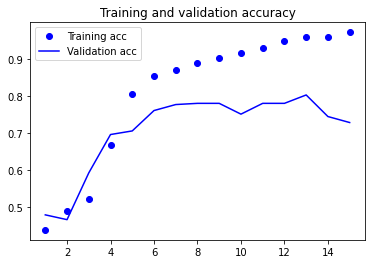

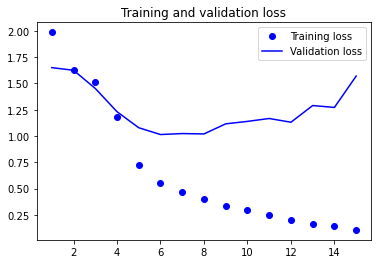

In [ ]:
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
loss = History.history['loss']
val_loss = History.history['val_loss']

import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()